**Setup for Dependecies**

In [ ]:
import sys
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the project directory path as the laboratory_2 folder
project_dir = '/content/drive/MyDrive/clasificacion_2_niveles/laboratory_2'

# Add the *parent* directory of laboratory_2 to sys.path
# This might still be necessary if other parts of your project rely on imports
# from the higher level directory.
parent_project_dir = '/content/drive/MyDrive/clasificacion_2_niveles'
if parent_project_dir not in sys.path:
    sys.path.append(parent_project_dir)
    print(f"Added {parent_project_dir} to sys.path")


# Change the current directory to the new project directory
# This is crucial for relative file paths within your laboratory_2 folder
if os.path.exists(project_dir):
    os.chdir(project_dir)
    print(f"Changed current directory to: {os.getcwd()}")
else:
    print(f"Project directory not found at: {project_dir}. Cannot change directory.")


# Add the project directory (laboratory_2) to sys.path
# This allows importing modules directly from within laboratory_2
if project_dir not in sys.path:
    sys.path.append(project_dir)
    print(f"Added {project_dir} to sys.path")


# Optional: Verify the updated sys.path and current working directory
print("\nUpdated sys.path:")
for p in sys.path:
    print(p)

print("\nCurrent working directory:")
print(os.getcwd())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Changed current directory to: /content/drive/MyDrive/clasificacion_2_niveles/laboratory_2

Updated sys.path:
/content
/env/python
/usr/lib/python311.zip
/usr/lib/python3.11
/usr/lib/python3.11/lib-dynload

/usr/local/lib/python3.11/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.11/dist-packages/IPython/extensions
/usr/local/lib/python3.11/dist-packages/setuptools/_vendor
/root/.ipython
/content/drive/MyDrive/clasificacion_2_niveles
/content/drive/MyDrive/clasificacion_2_niveles/laboratory_2
/tmp/tmpj6rgeltz

Current working directory:
/content/drive/MyDrive/clasificacion_2_niveles/laboratory_2


In [ ]:
import pickle
import json

import pandas as pd
import numpy as np
from time import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertConfig, BertTokenizer
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from tqdm import tqdm
import warnings


import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

def tokenize_text(text):
  return word_tokenize(text)

from tools_2 import get_data, load_dictionaries, preprocess_inference_data, DataProcessor, generate_hierarchy_map, ArticulosDataset, HierarchicalBertClassifierWithConstraint, build_import_data, FiltroAjuste



# Suppress all warnings
warnings.filterwarnings("ignore")


"""
Dependencies required to run this notebook:
- google-colab
- pandas
- numpy
- torch
- transformers
- scikit-learn
- tqdm
- nltk
- lab_utils (custom/local module, ensure it's available in your project directory)

To install the main dependencies, run:
%pip install pandas numpy torch transformers scikit-learn tqdm nltk

For Google Colab, the 'google.colab' package is pre-installed.
For 'tools', make sure the Python file or package is present in the specified Google Drive directory.
"""

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


"\nDependencies required to run this notebook:\n- google-colab\n- pandas\n- numpy\n- torch\n- transformers\n- scikit-learn\n- tqdm\n- nltk\n- lab_utils (custom/local module, ensure it's available in your project directory)\n\nTo install the main dependencies, run:\n%pip install pandas numpy torch transformers scikit-learn tqdm nltk\n\nFor Google Colab, the 'google.colab' package is pre-installed.\nFor 'tools', make sure the Python file or package is present in the specified Google Drive directory.\n"


Data Load and Processing

In [ ]:
#1 STEP: Load the new data for retraining

ruta = './datos/data_retrain_v1.csv' # Assuming this is your new data file
df_retrain = get_data(ruta)

ruta1 = './datos/dicaranceles.xlsx'
dic_aranceles = get_data(ruta1)


target_columns = ['Detalle Artículo', 'SAC 8 DIG' , 'Categoria', 'Familia',  'Descripción de Mercadería']
df_retrain = df_retrain[target_columns]


column_rename_map = {
    'Categoria': 'nombre_categoria',
    'Familia': 'familia',
    'Detalle Artículo': 'linea',
    'Descripción de Mercadería': 'descripcion',
    'SAC 8 DIG': 'cod_arancelario'
}

df_retrain = df_retrain.rename(columns=column_rename_map)



# 2 STEP: LOAD DICTIONARIES PENDING TO CREATE TABLES

stopwords_load_path = './diccionarios/stopwords_spanish.json'
replacement_dict_load_path = './diccionarios/replacement_dict.json'

stopwords_spanish, replacement_dict = load_dictionaries(stopwords_load_path, replacement_dict_load_path)

# 3 STEP: Preprocess the new data


df_retrain = build_import_data(
    resource_df=df_retrain,
    desc_col='descripcion',
    code_col='cod_arancelario',
    dict_df=dic_aranceles
)


stopwords_spanish, replacement_dict = load_dictionaries(stopwords_load_path, replacement_dict_load_path)

data_retrain = preprocess_inference_data(df_retrain, stopwords_spanish, replacement_dict)
data_retrain['subfamilia'] = data_retrain['linea']


# 4 STEP: CREATE VARIABLES Y AND X from the processed new data

Y_retrain = data_retrain[['nombre_categoria','familia']]
X_retrain = data_retrain[['corpus']]

# 5 STEP: Load the *existing* codificador and Encode the new labels

encoders_load_path = './diccionarios/codificador.pkl' # Path to your saved codificador
with open(encoders_load_path, 'rb') as f:
    codificador = pickle.load(f)

Y_retrain_encoded = codificador.encode_labels(Y_retrain)

# 6 STEP: Split the data into training and validation sets for retraining

X_train, X_test, Y_train, Y_test = train_test_split(X_retrain, Y_retrain_encoded, test_size=0.2, random_state=42)

# 7 STEP: RESET INDEX

X_train = X_train.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

hierarchy_map_encoded = generate_hierarchy_map(Y_retrain, Y_retrain_encoded, codificador)


# Save Lower Clases Diccionarios
fa = FiltroAjuste(root='./diccionarios/')
fa.create_baseline(
    df_retrain,
    target_column='subfamilia',
    descripcion_column='descripcion',
    min_samples=20
    )

(                   subfamilia  frecuencia  data_quality
 0    ABRILLANTADOR DE LLANTAS        66.0             1
 1        GRASAS Y LUBRICANTES        63.0             1
 2                       FOCOS        94.0             1
 3                    ADITIVOS        27.0             1
 4                   ALFOMBRAS       222.0             1
 ..                        ...         ...           ...
 736                   NATURAL        32.0             1
 737                   LAMPARA        27.0             1
 738                MATAMOSCAS         2.0             0
 739                   RAQUETA         7.0             0
 740                   TRAMPAS         8.0             0
 
 [741 rows x 3 columns],
                    keyword
 0             porta lentes
 1            cable arranca
 2           barra plastica
 3      articulos plasticos
 4         cobertor volante
 ..                     ...
 679  matamoscas extendible
 680   matamoscas plasticos
 681           raqueta mata
 682    r

# LLN SETUP

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F # Import functional for cross_entropy

class HierarchicalBertClassifierWithConstraint(nn.Module):
    def __init__(self, bert_model, num_labels_per_level, hierarchy_map_encoded, class_weights): # Accept class_weights
        super().__init__()
        self.bert = bert_model
        self.dropout_bert = nn.Dropout(bert_model.config.hidden_dropout_prob) # Dropout after BERT pooled output

        # Define classification heads for the first two levels
        self.classifier_categoria = nn.Linear(bert_model.config.hidden_size, num_labels_per_level['nombre_categoria_encoded'])
        self.dropout_categoria = nn.Dropout(p=0.3) # Dropout after categoria classifier

        self.classifier_familia = nn.Linear(
            bert_model.config.hidden_size + num_labels_per_level['nombre_categoria_encoded'],
            num_labels_per_level['familia_encoded']
        )
        self.dropout_familia = nn.Dropout(p=0.3) # Apply dropout after familia classifier


        # Removed classifiers for linea and subfamilia

        self.hierarchy_map_encoded = hierarchy_map_encoded
        self.class_weights = class_weights # Store class_weights

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True
        )

        pooled_output = outputs.hidden_states[-1][:, 0, :]
        pooled_output = self.dropout_bert(pooled_output) # Apply dropout after BERT

        # --- Hierarchical Classification for first two levels ---

        logits_categoria = self.classifier_categoria(pooled_output)
        logits_categoria = self.dropout_categoria(logits_categoria) # Apply dropout

        input_to_familia = torch.cat((pooled_output, logits_categoria.detach()), dim=-1)
        logits_familia = self.classifier_familia(input_to_familia)
        logits_familia = self.dropout_familia(logits_familia) # Apply dropout


        # Removed calculations for linea and subfamilia logits

        logits = {
            'nombre_categoria_encoded': logits_categoria,
            'familia_encoded': logits_familia,
            # Removed logits for linea and subfamilia
        }


        loss = None
        if labels is not None:
             # Use class weights for CrossEntropyLoss for each level
            loss_fct_categoria = nn.CrossEntropyLoss(weight=self.class_weights['nombre_categoria_encoded'])
            loss_fct_familia = nn.CrossEntropyLoss(weight=self.class_weights['familia_encoded'])
            # Removed loss functions for linea and subfamilia


            loss_categoria = loss_fct_categoria(logits_categoria, labels[:, 0])
            loss_familia = loss_fct_familia(logits_familia, labels[:, 1])
            # Removed loss calculations for linea and subfamilia

            # --- Calculate Hierarchical Penalty ---
            # Adjust penalty calculation for only two levels
            hierarchical_penalty = self.calculate_hierarchical_penalty(logits, labels)

            # Total loss = sum of individual weighted losses + hierarchical penalty
            loss = loss_categoria + loss_familia + hierarchical_penalty # Adjusted total loss


        return {
            'logits': logits,
            'loss': loss
        }


    def calculate_hierarchical_penalty(self, logits, labels):
        penalty = 0
        batch_size = labels.size(0)
        device = labels.device # Get device from labels

        # Penalty for inconsistent familia prediction given the true categoria
        # Get predicted *indices* for penalty calculation
        predicted_categorias_indices = torch.argmax(logits['nombre_categoria_encoded'], dim=1)
        true_familias_indices = labels[:, 1] # True indices

        for i in range(batch_size):
            true_categoria_encoded = labels[i, 0].item()
            predicted_familia_encoded = torch.argmax(logits['familia_encoded'][i]).item() # Predicted index

            # Check if the predicted familia is a valid child of the true categoria
            # Access the hierarchy map using encoded indices
            valid_familias_for_categoria = self.hierarchy_map_encoded.get('nombre_categoria_encoded', {}).get(true_categoria_encoded, [])
            if predicted_familia_encoded not in valid_familias_for_categoria:
                penalty += 1 # Simple penalty, you can adjust the value

        # Removed penalty calculations for linea and subfamilia


        # Convert penalty to a tensor on the correct device
        return torch.tensor(penalty, dtype=torch.float, device=device) # You might want to scale this penalty

In [ ]:
# Calculate class weights *before* initializing the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define device early

class_weights = {}
for col in Y_train.columns:
    class_counts = Y_train[col].value_counts()
    # Get all unique classes, including those not in the training set (if any)
    # to ensure the weight tensor has the correct size
    all_classes = Y_retrain_encoded[col].unique()
    weights_list = []
    for cls in sorted(all_classes): # Sort to match potential internal ordering
        count = class_counts.get(cls, 0) # Get count, default to 0 if class not in train
        # Calculate weight; add epsilon for stability and handle 0 counts gracefully
        weight = 1.0 / (count + 1e-5)
        weights_list.append(weight)

    weights = torch.tensor(weights_list, dtype=torch.float).to(device)
    # Normalize the weights (optional, but good practice)
    weights = weights / weights.sum()
    class_weights[col] = weights

In [ ]:
# Load Pre-trained BERT tokenizer and create tensor datasets

tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
train_dataset = ArticulosDataset(X_train['corpus'], Y_train, tokenizer, max_len=512)
val_dataset = ArticulosDataset(X_test['corpus'], Y_test, tokenizer, max_len=512)

# Create data loaders

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load Pre-trained BERT model

bert_model = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

# Get the number of unique labels for each classification level

num_labels_per_level = {}
for col in Y_retrain_encoded.columns:
    # Access the label_encoders attribute of the DataProcessor object
    # and get the number of classes from the corresponding encoder
    original_col_name = col.replace('_encoded', '')
    num_labels_per_level[col] = len(codificador.label_encoders[original_col_name].classes_)



# Initialize custom multi-output classifier

#model = BertMultiOutputClassifier(bert_model, num_labels_per_level)
model = HierarchicalBertClassifierWithConstraint(bert_model, num_labels_per_level, hierarchy_map_encoded, class_weights)


# Load the state dictionary from the previously trained model
# We will only load the BERT weights and skip the classification heads
model_load_path = './modelos/BERT_CLASIFICADOR_ARTICULOS_NIVELES_2_V1_train_pipeline.pth' # Path to the model you want to retrain

# Load the full state dictionary
pretrained_state_dict = torch.load(model_load_path, map_location=device)

# Filter out the keys corresponding to the classification heads
# These keys start with 'classifier_'
state_dict_to_load = {k: v for k, v in pretrained_state_dict.items() if not k.startswith('classifier_')}

# Load the filtered state dictionary into the new model
# Set strict=False to ignore the missing classification head keys
model.load_state_dict(state_dict_to_load, strict=False)


# === FREEZE LOWER BERT LAYERS ===
# Freeze all parameters in the embedding layer
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

# Freeze the first N encoder layers (e.g., 8 out of 12)
N = 8  # Change this value as needed (for bert-base: 12 total layers)
for layer in model.bert.encoder.layer[:N]:
    for param in layer.parameters():
        param.requires_grad = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #####################################################
model.to(device)                                                                              #GPU or TPU
                                                                       #####################################################

# Define optimizer and loss function

optimizer_grouped_parameters = [
    {"params": model.bert.parameters(), "weight_decay": 1e-4},
    {"params": list(model.classifier_categoria.parameters()) +
               list(model.classifier_familia.parameters()) },
]
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Training and Evaluation

In [ ]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True) # You can adjust factor and patience

# Early stopping parameters
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop_patience = 2 # Set patience for early stopping to 2

epochs = 6  #early stopping will stop training

# Lists to store metrics
train_losses = []
val_losses = []
accuracies_categoria = []
accuracies_familia = []
# Removed lists for linea and subfamilia accuracies

balanced_accuracies_categoria = []
balanced_accuracies_familia = []
# Removed lists for linea and subfamilia balanced accuracies

exact_match_accuracies = []
average_balanced_accuracies = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        batch_total_loss = outputs['loss']

        batch_total_loss.backward()
        optimizer.step()

        total_train_loss += batch_total_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}")

    # Evaluation loop
    model.eval()
    total_val_loss = 0
    predictions_categoria = []
    predictions_familia = []
    # Removed lists for linea and subfamilia predictions

    true_labels_categoria = []
    true_labels_familia = []
    # Removed lists for linea and subfamilia true labels


    exact_matches = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']
            logits = outputs['logits']

            preds_categoria = torch.argmax(logits['nombre_categoria_encoded'], dim=1)
            preds_familia = torch.argmax(logits['familia_encoded'], dim=1)
            # Removed predictions for linea and subfamilia

            total_val_loss += loss.item()

            predictions_categoria.extend(preds_categoria.cpu().numpy())
            predictions_familia.extend(preds_familia.cpu().numpy())
            # Removed extending predictions for linea and subfamilia

            true_labels_categoria.extend(labels[:, 0].cpu().numpy())
            true_labels_familia.extend(labels[:, 1].cpu().numpy())
            # Removed extending true labels for linea and subfamilia


            for i in range(labels.size(0)):
                # Adjusted exact match check for only two levels
                if torch.equal(torch.stack([preds_categoria[i], preds_familia[i]]), labels[i, :2]):
                    exact_matches += 1


    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    accuracy_categoria = accuracy_score(true_labels_categoria, predictions_categoria)
    accuracy_familia = accuracy_score(true_labels_familia, predictions_familia)
    # Removed accuracy calculations for linea and subfamilia


    accuracies_categoria.append(accuracy_categoria)
    accuracies_familia.append(accuracy_familia)
    # Removed appending accuracies for linea and subfamilia


    balanced_accuracy_categoria = balanced_accuracy_score(true_labels_categoria, predictions_categoria)
    balanced_accuracy_familia = balanced_accuracy_score(true_labels_familia, predictions_familia)
    # Removed balanced accuracy calculations for linea and subfamilia


    balanced_accuracies_categoria.append(balanced_accuracy_categoria)
    balanced_accuracies_familia.append(balanced_accuracy_familia)
    # Removed appending balanced accuracies for linea and subfamilia


    exact_match_accuracy = exact_matches / len(val_dataset)
    exact_match_accuracies.append(exact_match_accuracy)

    # Adjusted average balanced accuracy calculation for only two levels
    average_balanced_accuracy = (balanced_accuracy_categoria + balanced_accuracy_familia) / 2
    average_balanced_accuracies.append(average_balanced_accuracy)


    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss}, ")
    print(f"Categoria Acc: {accuracy_categoria:.4f}, Familia Acc: {accuracy_familia:.4f}")
    # Removed printing accuracies for linea and subfamilia

    print(f"Categoria Bal Acc: {balanced_accuracy_categoria:.4f}, Familia Bal Acc: {balanced_accuracy_familia:.4f}")
    # Removed printing balanced accuracies for linea and subfamilia

    print(f"Exact Match Acc: {exact_match_accuracy:.4f}, Average Balanced Acc: {average_balanced_accuracy:.4f}")

    # Learning rate scheduler step
    scheduler.step(avg_val_loss)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Optionally save the best model here if you want to load it later
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stop_patience:
            print("Early stopping!")
            break # Stop training loop

# Create a table with the results
results_df = pd.DataFrame({
    'Epoch': range(1, len(train_losses) + 1), # Adjust epoch range based on early stopping
    'Training Loss': train_losses,
    'Validation Loss': val_losses,
    'Validation Accuracy (Categoria)': accuracies_categoria,
    'Validation Accuracy (Familia)': accuracies_familia,
    # Removed accuracy columns for linea and subfamilia

    'Validation Balanced Accuracy (Categoria)': balanced_accuracies_categoria,
    'Validation Balanced Accuracy (Familia)': balanced_accuracies_familia,
    # Removed balanced accuracy columns for linea and subfamilia

    'Exact Match Accuracy': exact_match_accuracies,
    'Average Balanced Accuracy': average_balanced_accuracies
})

print("\nTraining Results:")
display(results_df)

Training Epoch 1: 100%|██████████| 1182/1182 [06:49<00:00,  2.89it/s]


Epoch 1, Training Loss: 14.778769007592436


Evaluating: 100%|██████████| 296/296 [01:03<00:00,  4.65it/s]


Epoch 1, Validation Loss: 5.4255752084223, 
Categoria Acc: 0.8964, Familia Acc: 0.7860
Categoria Bal Acc: 0.9151, Familia Bal Acc: 0.8142
Exact Match Acc: 0.7490, Average Balanced Acc: 0.8647


Training Epoch 2: 100%|██████████| 1182/1182 [06:48<00:00,  2.89it/s]


Epoch 2, Training Loss: 8.940753462350914


Evaluating: 100%|██████████| 296/296 [01:03<00:00,  4.65it/s]


Epoch 2, Validation Loss: 3.686129055313162, 
Categoria Acc: 0.9301, Familia Acc: 0.8676
Categoria Bal Acc: 0.9447, Familia Bal Acc: 0.8637
Exact Match Acc: 0.8434, Average Balanced Acc: 0.9042


Training Epoch 3: 100%|██████████| 1182/1182 [06:48<00:00,  2.89it/s]


Epoch 3, Training Loss: 7.42959507205563


Evaluating: 100%|██████████| 296/296 [01:03<00:00,  4.66it/s]


Epoch 3, Validation Loss: 3.1192819026072285, 
Categoria Acc: 0.9419, Familia Acc: 0.8812
Categoria Bal Acc: 0.9527, Familia Bal Acc: 0.8891
Exact Match Acc: 0.8684, Average Balanced Acc: 0.9209


Training Epoch 4: 100%|██████████| 1182/1182 [06:48<00:00,  2.89it/s]


Epoch 4, Training Loss: 6.93362661031297


Evaluating: 100%|██████████| 296/296 [01:03<00:00,  4.65it/s]


Epoch 4, Validation Loss: 2.541929536071178, 
Categoria Acc: 0.9466, Familia Acc: 0.8943
Categoria Bal Acc: 0.9600, Familia Bal Acc: 0.9063
Exact Match Acc: 0.8776, Average Balanced Acc: 0.9332


Training Epoch 5: 100%|██████████| 1182/1182 [06:48<00:00,  2.90it/s]


Epoch 5, Training Loss: 6.6908126676143125


Evaluating: 100%|██████████| 296/296 [01:03<00:00,  4.65it/s]


Epoch 5, Validation Loss: 2.4237392322235816, 
Categoria Acc: 0.9483, Familia Acc: 0.9044
Categoria Bal Acc: 0.9551, Familia Bal Acc: 0.9123
Exact Match Acc: 0.8904, Average Balanced Acc: 0.9337


Training Epoch 6: 100%|██████████| 1182/1182 [06:47<00:00,  2.90it/s]


Epoch 6, Training Loss: 6.765792249523847


Evaluating: 100%|██████████| 296/296 [01:03<00:00,  4.66it/s]

Epoch 6, Validation Loss: 2.031100322869984, 
Categoria Acc: 0.9545, Familia Acc: 0.9167
Categoria Bal Acc: 0.9645, Familia Bal Acc: 0.9161
Exact Match Acc: 0.8997, Average Balanced Acc: 0.9403

Training Results:


,Epoch,Training Loss,Validation Loss,Validation Accuracy (Categoria),Validation Accuracy (Familia),Validation Balanced Accuracy (Categoria),Validation Balanced Accuracy (Familia),Exact Match Accuracy,Average Balanced Accuracy
0,1,14.778769,5.425575,0.896402,0.786032,0.915112,0.814235,0.748995,0.864674
1,2,8.940753,3.686129,0.930053,0.867619,0.944719,0.863661,0.843386,0.904190
2,3,7.429595,3.119282,0.941905,0.881164,0.952723,0.889087,0.868360,0.920905
3,4,6.933627,2.541930,0.946561,0.894286,0.960014,0.906300,0.877566,0.933157
4,5,6.690813,2.423739,0.948254,0.904444,0.955054,0.912298,0.890370,0.933676
5,6,6.765792,2.031100,0.954497,0.916720,0.964490,0.916089,0.899683,0.940290


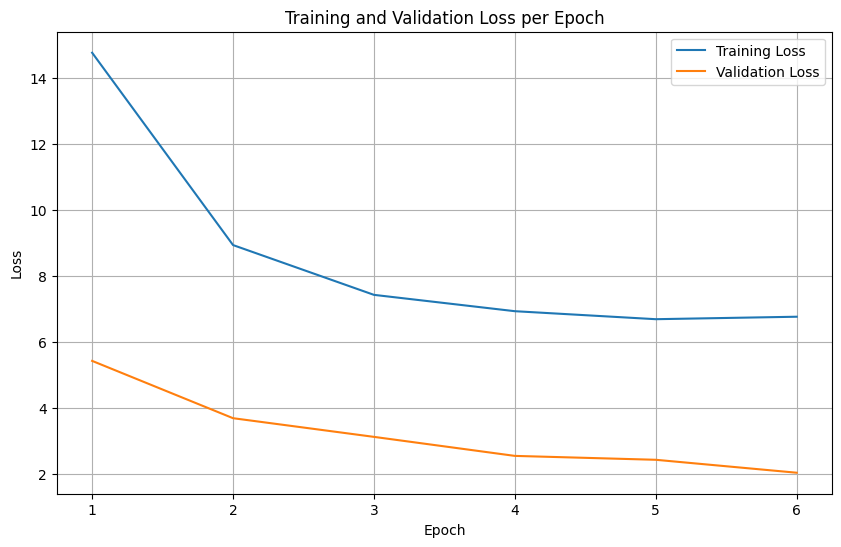

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(results_df['Epoch'], results_df['Training Loss'], label='Training Loss')
plt.plot(results_df['Epoch'], results_df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# SECCION DE GUARDADO DEL MODELO Y DICCIONARIOS

In [ ]:
import pickle

# Define paths to save the model and the encoders in your Google Drive
model_save_path = './modelos/BERT_CLASIFICADOR_ARTICULOS_NIVELES_2_V1_retrain_pipeline.pth' # Replace with your desired path for model and encoders


# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

# Save the codificador object using pickle
encoders_save_path = './diccionarios/codificador.pkl' # Replace with your desired path for the encoders
with open(encoders_save_path, 'wb') as f:
    pickle.dump(codificador, f)

print(f"Model state dictionary saved to {model_save_path}")
print(f"Codificador object saved to {encoders_save_path}")

Model state dictionary saved to ./modelos/BERT_CLASIFICADOR_ARTICULOS_NIVELES_2_V1_retrain_pipeline.pth
Codificador object saved to ./diccionarios/codificador.pkl


In [ ]:

# Define the path to save the class weights
class_weights_save_path = './diccionarios/class_weights.pth' # Using .pth is common for PyTorch saves

# Save the class_weights dictionary
torch.save(class_weights, class_weights_save_path)

print(f"Class weights saved to {class_weights_save_path}")


Class weights saved to ./diccionarios/class_weights.pth


In [ ]:
import json
# Define the path to save the hierarchy_map_encoded
hierarchy_map_save_path = './diccionarios/hierarchy_map_encoded.json'

# Convert numpy int64 keys and potentially values to standard Python types
serializable_hierarchy_map = {}
for level, level_map in hierarchy_map_encoded.items():
    serializable_level_map = {}
    for key, values in level_map.items():
        # Convert the key to a standard Python int
        serializable_key = int(key)
        # Convert any numpy int64 values in the list to standard Python ints
        serializable_values = [int(v) if isinstance(v, np.int64) else v for v in values]
        serializable_level_map[serializable_key] = serializable_values
    serializable_hierarchy_map[level] = serializable_level_map


# Save the serializable_hierarchy_map dictionary to a JSON file
with open(hierarchy_map_save_path, 'w') as f:
    json.dump(serializable_hierarchy_map, f)

print(f"Hierarchy map saved to {hierarchy_map_save_path}")

Hierarchy map saved to ./diccionarios/hierarchy_map_encoded.json


In [ ]:
# Define paths to save the retrained model and related files
model_save_path_retrained = './modelos/BERT_CLASIFICADOR_ARTICULOS_NIVELES_2_V1_retrain_pipeline.pth' # New path for the retrained model


# Save the retrained model's state dictionary
torch.save(model.state_dict(), model_save_path_retrained)

# Save the codificador object using pickle (if it has changed, which it shouldn't in this retraining scenario, but good practice)
# If the new data contains new classes not seen before, the codificador might be updated
# It's generally safer to save the updated codificador.
encoders_save_path_retrained = './diccionarios/codificador_retrain_V2.pkl' # Save the codificador used for retraining
with open(encoders_save_path_retrained, 'wb') as f:
    pickle.dump(codificador, f)

# Define the path to save the updated class weights
class_weights_save_path_retrained = './diccionarios/class_weights_retrain_V2.pth' # Save the class weights from the retraining data

# Save the class_weights dictionary
torch.save(class_weights, class_weights_save_path_retrained)


# Define the path to save the updated hierarchy_map_encoded
hierarchy_map_save_path_retrained = './diccionarios/hierarchy_map_encoded_retrain_V2.json' # Save the hierarchy map from the retraining data

# Convert numpy int64 keys and potentially values to standard Python types
serializable_hierarchy_map_retrained = {}
for level, level_map in hierarchy_map_encoded.items():
    serializable_level_map = {}
    for key, values in level_map.items():
        # Convert the key to a standard Python int
        serializable_key = int(key)
        # Convert any numpy int64 values in the list to standard Python ints
        serializable_values = [int(v) if isinstance(v, np.int64) else v for v in values]
        serializable_level_map[serializable_key] = serializable_values
    serializable_hierarchy_map_retrained[level] = serializable_level_map


# Save the serializable_hierarchy_map dictionary to a JSON file
with open(hierarchy_map_save_path_retrained, 'w') as f:
    json.dump(serializable_hierarchy_map_retrained, f)

print(f"Retrained Model state dictionary saved to {model_save_path_retrained}")
print(f"Updated Codificador object saved to {encoders_save_path_retrained}")
print(f"Updated Class weights saved to {class_weights_save_path_retrained}")
print(f"Updated Hierarchy map saved to {hierarchy_map_save_path_retrained}")

Retrained Model state dictionary saved to ./modelos/BERT_CLASIFICADOR_ARTICULOS_NIVELES_2_V1_retrain_pipeline.pth
Updated Codificador object saved to ./diccionarios/codificador_retrain_V2.pkl
Updated Class weights saved to ./diccionarios/class_weights_retrain_V2.pth
Updated Hierarchy map saved to ./diccionarios/hierarchy_map_encoded_retrain_V2.json
